In [32]:
import inspect
import json
import os
import time

import numpy as np
from functools import wraps
import pandas as pd
import seaborn as sns
import random
import tempfile

import pathlib
import zstandard as zstd
import abc
import brotli
import zlib

Platform class

In [61]:


class Platform:
    def __init__(self, algorithm, processing, table_path):
        self.algorithm = algorithm
        self.processing = processing
        self.table_path = table_path
        self.logs = False

        self.benchmark = {"name": type(self.algorithm).__name__, "table_path": table_path}

    def start(self, run_type="test", logs=False):
        self.logs = logs

        if self.logs:
            if isinstance(self.algorithm, LosslessCompressionAlgorithm):
                self.benchmark["isLossLess"] = True
            else:
                self.benchmark["isLossLess"] = False

            if isinstance(self.algorithm, LearningCompressionAlgorithm):
                self.benchmark["isLearning"] = True
            else:
                self.benchmark["isLearning"] = False

        if run_type == 'test':
            self.test()
        elif run_type == 'compress':
            self.preprocess_and_compress()
        elif run_type == 'decompress':
            self.decompress_and_postprocess()

    def measure_time(flag):
        def decorator(func):
            def wrapper(self, *args, **kwargs):
                start_time = time.time()
                result = func(self, *args, **kwargs)
                end_time = time.time()

                if getattr(self, flag):
                    print(f"Function {func.__name__} took {end_time - start_time} seconds to execute.")
                    self.benchmark[func.__name__ + "_time"] = end_time - start_time

                return result

            return wrapper

        return decorator

    def get_file_names(self):
        return {"compressed": self.table_path + "_compressed",
                "decompressed": self.table_path + "_decompressed",
                "preprocessed": self.table_path + "_preprocessed",
                "postprocessed": self.table_path + "_postprocessed"}

    @measure_time("logs")
    def preprocess_and_compress(self):
        filenames = self.get_file_names()

        self.processing.do_preprocess(self.table_path, filenames['preprocessed'])
        self.algorithm.compress(filenames["preprocessed"], filenames["compressed"])

        if self.logs:
            compression_rate = self.get_compression_rate(self.table_path, filenames["compressed"])

            self.benchmark["compression_rate"] = compression_rate
        return 0

    @measure_time("logs")
    def decompress_and_postprocess(self):
        filenames = self.get_file_names()


        self.algorithm.decompress(filenames["compressed"], filenames["decompressed"])

        self.processing.do_postprocess(filenames["decompressed"], filenames["postprocessed"])

        if self.logs:
            loss_rate = self.get_loss_rate(self.table_path, filenames["decompressed"])
            self.benchmark["loss_rate"] = loss_rate

        return 0

    @measure_time("logs")
    def test(self):
        self.preprocess_and_compress()
        self.decompress_and_postprocess()
        return 0  #TODO: result codes

    def get_compression_rate(self, input_file, compressed_file):  #I'm assuming compressed_table is actually bytes-like
        input_file.seek(0, os.SEEK_END)
        compressed_file.seek(0, os.SEEK_END)
        print(compressed_file.name, input_file.tell(), compressed_file.tell())
        return compressed_file.tell() / input_file.tell()

    def get_loss_rate(self, input_file, decompressed_file):
        print("I am dummy: ", inspect.currentframe().f_code.co_name)
        return random.randint(0, 20)



In [27]:
def json_platform(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)

    platform = Platform(globals()[config["Algorithm"]](), globals()[config["Processing"]](), config["table_path"])
    platform.start(config["run_type"], config["logs"])


json_platform("plug_config.json")

b''
I am dummy compression


TypeError: can only concatenate str (not "int") to str

Compression Algorithm Classes

In [28]:
import abc


class CompressionAlgorithm(abc.ABC):
    def __init__(self):
        ...

    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def compress(self, table_file, compressed_file):
        ...

    @abc.abstractmethod
    def decompress(self, compressed_file, decompressed_file):
        ...


class LearningCompressionAlgorithm(CompressionAlgorithm):

    @abc.abstractmethod
    def fit(self, training_data):
        ...


class NonLearningCompressionAlgorithm(CompressionAlgorithm):
    ...


class LosslessCompressionAlgorithm(CompressionAlgorithm):
    ...


class LossyCompressionAlgorithm(CompressionAlgorithm):
    ...

In [29]:
class DummyCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'Dummy Compression Algorithm'

    def compress(self, table_file, compressed_file):
        table_file.seek(0)
        compressed_file.seek(0)
        compressed_file.write(table_file.read())
        print(table_file.read())
        print("I am dummy compression")
        return 0  # TODO: status codes

    def decompress(self, compressed_file, decompressed_file):
        compressed_file.seek(0)
        decompressed_file.seek(0)
        decompressed_file.write(compressed_file.read())
        time.sleep(1)
        print("I am dummy decompression")
        return 0  # TODO: status codes

In [30]:
class ZstdLibraryCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'zstd library'

    def compress(self, table_file, compressed_file):
        table_file.seek(0)
        compressed_file.seek(0)
        compressor = zstd.ZstdCompressor(level=22)
        compressor.copy_stream(table_file, compressed_file)
        return 0

    def decompress(self, compressed_file, decompressed_file):
        compressed_file.seek(0)
        decompressed_file.seek(0)
        decompressor = zstd.ZstdDecompressor()
        decompressor.copy_stream(compressed_file, decompressed_file)
        return 0

In [31]:
class BrotliLibraryCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'brotli library'

    def compress(self, table_file, compressed_file):
        table_file.seek(0)
        compressed_file.seek(0)
        compressed_file.write(brotli.compress(table_file.read()))
        return 0

    def decompress(self, compressed_file, decompressed_file):
        compressed_file.seek(0)
        decompressed_file.seek(0)
        decompressed_file.write(brotli.decompress(compressed_file.read()))
        return 0

In [33]:
class ZlibCompression(NonLearningCompressionAlgorithm, LosslessCompressionAlgorithm):
    name = 'zlib'

    def compress(self, table_file, compressed_file):
        table_file.seek(0)
        compressed_file.seek(0)

        data = table_file.read()
        compressed_data = zlib.compress(data)
        compressed_file.write(compressed_data)

    def decompress(self, compressed_file, decompressed_file):
        compressed_file.seek(0)
        decompressed_file.seek(0)

        data = compressed_file.read()
        decompressed_data = zlib.decompress(data)
        decompressed_file.write(decompressed_data)

Processing Classes

In [34]:
class Processing(abc.ABC):
    def __init__(self):
        ...

    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def do_preprocess(self, raw_file, processed_file):
        ...

    @abc.abstractmethod
    def do_postprocess(self, processed_file):
        ...

In [35]:
class DummyProcessing(Processing):
    name = "Dummy Pre/Post-Processing"

    def do_preprocess(self, raw_file, processed_file):
        raw_file.seek(0)
        processed_file.seek(0)
        processed_file.write(raw_file.read())
        return 0  # TODO: replace with enum / status codes

    def do_postprocess(self, processed_file):
        return 0  # TODO: replace with enum/status codes


Testing

In [39]:
benchmarks = []
Algos = [DummyCompressionAlgorithm(), ZlibCompression(), ZstdLibraryCompressionAlgorithm(), BrotliLibraryCompressionAlgorithm()]
Processes = [DummyProcessing()]
for algo in Algos:
    for proc in Processes:
        a = Platform(algo, proc, "data/sample_dataset.csv")
        a.start("test", logs=True)
        print(a.benchmark)
        benchmarks.append(a.benchmark)
        print("---------------------")

b''
I am dummy compression
data/sample_dataset.csv_compressed 178773868 178773868
Function preprocess_and_compress took 1.446197748184204 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.4190223217010498 seconds to execute.
Function test took 2.865220069885254 seconds to execute.
{'name': 'DummyCompressionAlgorithm', 'table_path': 'data/sample_dataset.csv', 'isLossLess': True, 'isLearning': False, 'compression_rate': 1.0, 'preprocess_and_compress_time': 1.446197748184204, 'loss_rate': 5, 'decompress_and_postprocess_time': 1.4190223217010498, 'test_time': 2.865220069885254}
---------------------
data/sample_dataset.csv_compressed 178773868 64455677
Function preprocess_and_compress took 11.156059980392456 seconds to execute.
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0556626319885254 seconds to execute.
Function test took 12.211722612380981 seconds to execute.
{'name': 'ZlibCompression', 'table_p

In [ ]:
#1. replace json with arguments of the class | DONE
#2. do not keep table in class instance | DONE
#3. change names of the Platform to more relevant | DONE
#4. rename compression to compress | DONE
#5. add ability to not compress tables every time Platform being created | I can just pass already preprocessed table to Platform
#and also pass the flush preprocessing class which do nothing

In [40]:
import matplotlib.pyplot as plt


def plot_graphics(n_values):
    plt.bar(range(len(n_values)), n_values)
    plt.title('Comparison of n Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


In [41]:
def plot_benchmarks(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.barplot(x='index', y=column_name, data=df)


def plot_scatter(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.scatterplot(x='index', y=column_name, data=df)


def plot_hist(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.histplot(x='index', y=column_name, data=df)



5
0
2
6


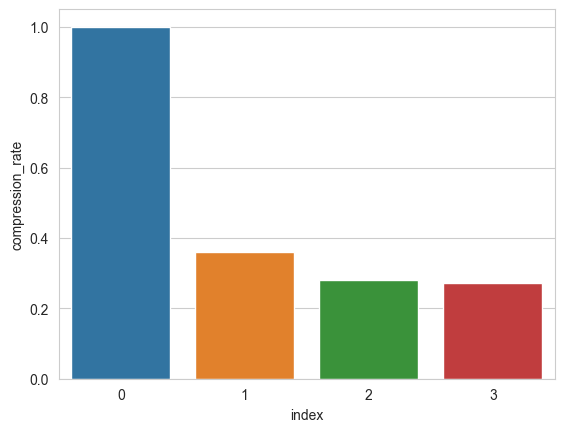

In [42]:
plot_benchmarks(benchmarks, "compression_rate")
for i in benchmarks:
    print(i["loss_rate"])

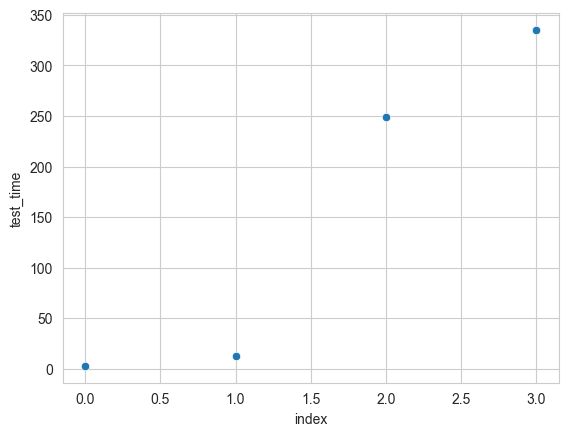

In [43]:
plot_scatter(benchmarks, "test_time")

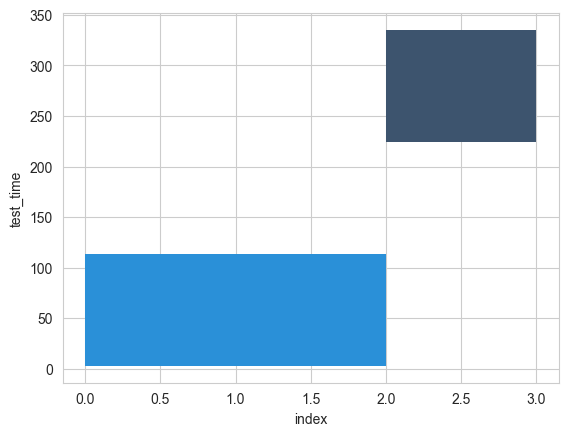

In [44]:
plot_hist(benchmarks, "test_time")